# Automated AI Form Filler

Steps:
1. Find the form and determines what needs to be completed.
2. Retrieves the Information from the files.
3. It enters the information in the correct spots on the form.

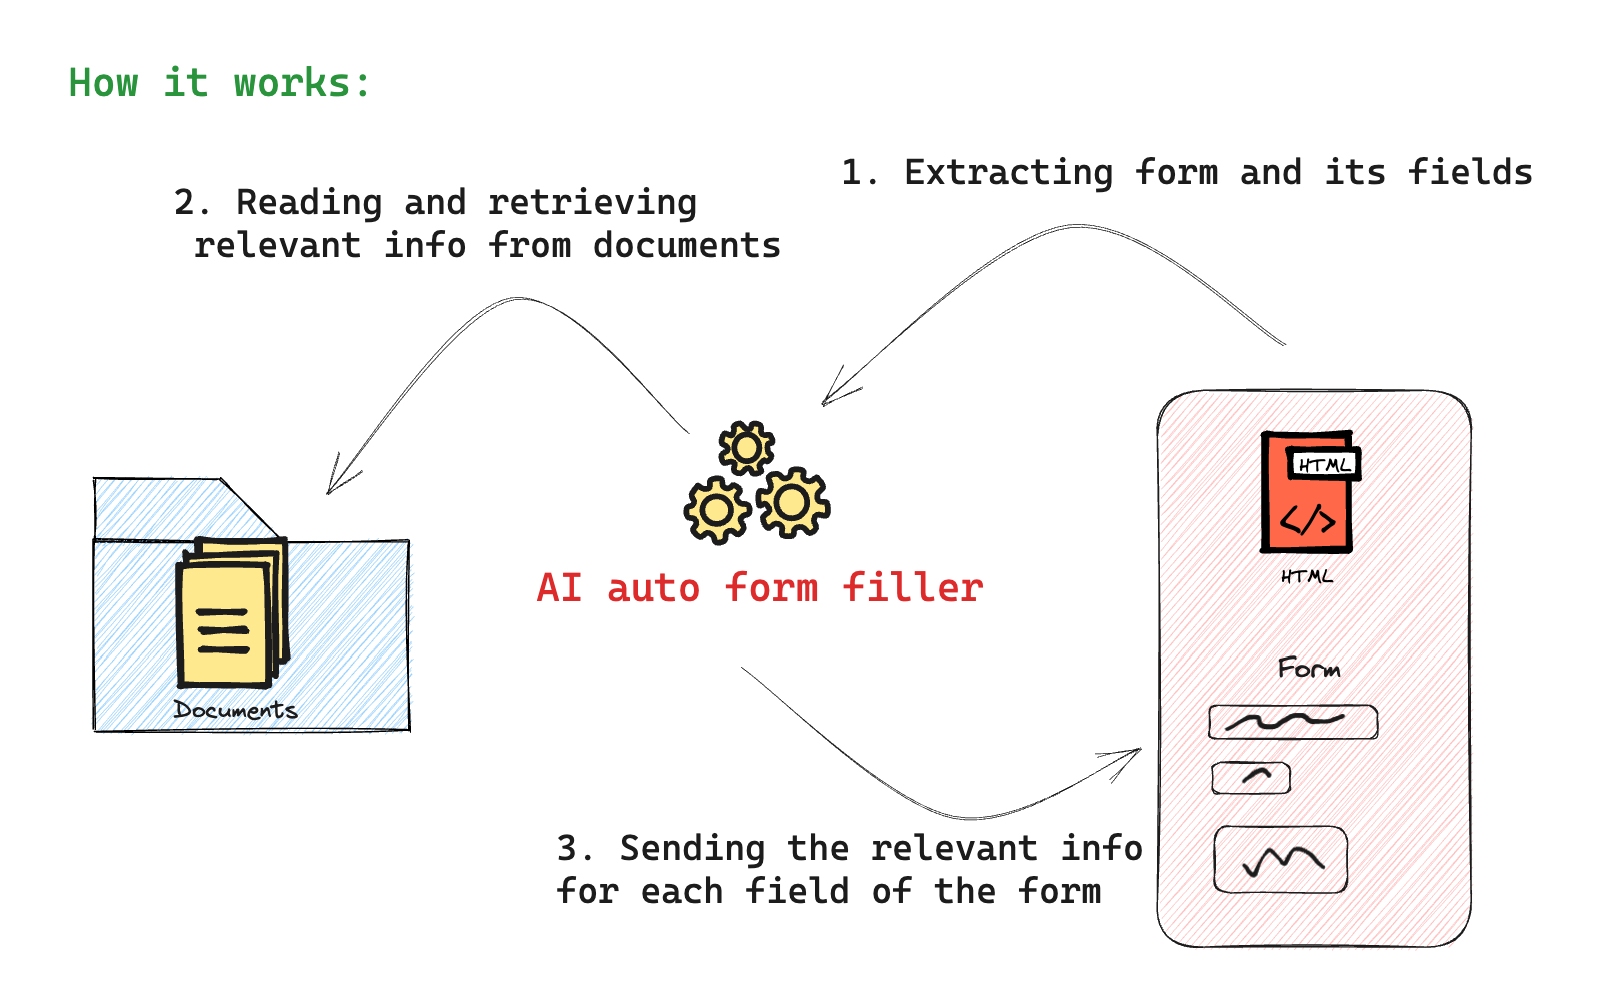
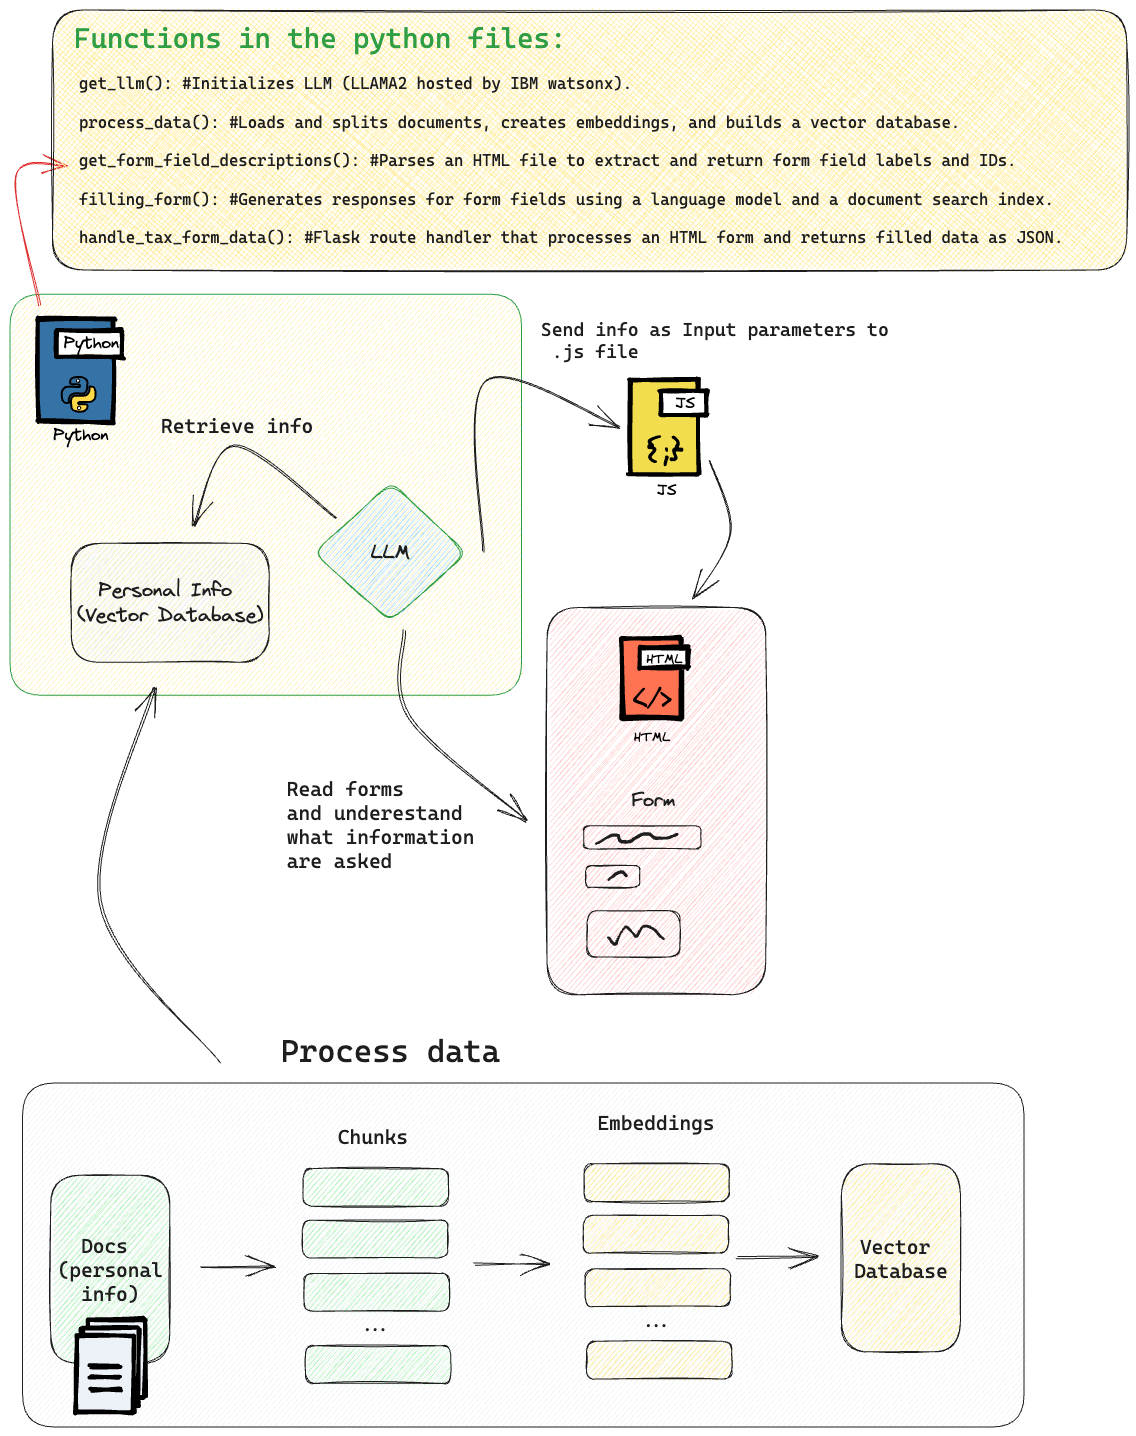

# 1. Importing Libraries

In [4]:
# !pip install -r requirements.txt
# Import required libraries from various modules.
from ibm_watson_machine_learning.foundation_models.extensions.langchain import WatsonxLLM
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams
from ibm_watson_machine_learning.foundation_models import Model

# langchain library for embeddings, text splitting, and conversational retrieval.
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts.prompt import PromptTemplate

# Document loader and vector store modules for processing PDFs.
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.vectorstores import FAISS

# BeautifulSoup for parsing HTML content.
from bs4 import BeautifulSoup

# Flask for web server and CORS for cross-origin resource sharing.
from flask import Flask, jsonify, render_template
from flask_cors import CORS

# 2. Initialize the AI Model

Set Parameters: MAX_NEW_TOKENS to generate maximum tokens per run
                TEMPERATURE controls randomness in generation
Authrntications are not pre arranged, so no need of creating an API key

get_llm(): 
This function initializes an AI language model that is provided by IBM Watson (LLM). 
It’s used later to understand questions and to provide relevant answers from the documents.

In [ ]:
def get_llm():
    # credentials fro accessing IBM Watson services.
    # Create an API Key 
    # the below is sample credentials for the specific cloud
    my_credentials = {
        "url":"https://us-south.ml.cloud.ibm.com",
    }
    
    # parameters for controlling the generation of text by model.
    
    params = {
        GenParams.MAX_NEW_TOKENS: 256,
        GenParams.TEMPERATURE:0.0,
    }
    
    # initialize the model with specific ID and Credentials
    LLAMA2_model = Model(
        model_id = 'meta-llama/llama-2-70b-chat',
        credentials = my_credentials,
        params = params,
        project_id = 'skills-network'
    )
    
    # create and return Watson language Model.
    llm = WatsonxLLM(model=LLAMA2_model)
    return llm
# Sample Test

llm = get_llm()
llm_output = llm.predict("Tell me how it's like to live in Toronto?")
print(llm_output)

# 3. Data Processing and Creating Vector Database

Vector Database Purpose:
Stores information in a format that computers can quickly process.
Converts text into mathematical vectors, representing the text's meaning.

Why It's Needed:
Efficiently handles and searches through large amounts of text data.
Enables quick retrieval of specific information from documents, akin to finding a needle in a haystack.

Benefits:
Faster search compared to manual document reading.
Enhanced accuracy as AI understands context and meaning through vector representations.

Loading Documents:
PDF files are loaded from the "info" directory using PyPDFDirectoryLoader.

Splitting Text:
Documents are divided into smaller chunks using RecursiveCharacterTextSplitter for easier processing.

Creating Embeddings:
Pretrained model "sentence-transformers/all-MiniLM-L6-v2" from Hugging Face converts text chunks into embeddings.
Each embedding captures semantic meaning, context, and word relationships within the text.

Indexing for Retrieval:
Embeddings are indexed using FAISS (Facebook AI Similarity Search) for efficient search and retrieval.
FAISS allows fast retrieval of relevant text pieces based on query similarity.


In [9]:
def process_data():
    # Load PDF documents from a specified directory.
    loader = PyPDFDirectoryLoader("Docs")
    docs = loader.load()

    print("\ntype of docs:",type(docs))
    print("\n docs:", docs)

    # Split the text from documents for better processing.
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=50)
    texts = text_splitter.split_documents(docs)

    print("\ntype of texts:",type(texts))
    print("\ntexts:",texts)

    # Create embeddings for the text data.
    embeddings = HuggingFaceInstructEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    print("\ntype of embeddings:",type(embeddings))
    print("\nembeddings:",embeddings)

    # Index the documents using FAISS for efficient retrieval.
    db = FAISS.from_documents(texts, embeddings)

    print("\ntype of vector db:",type(db))

    return db

# process_data()  

# 4. Form Field Identification

Parse HTML: Read the HTML file and use BeautifulSoup to parse it.

Extract form fields: Identify form elements like input boxes, 
drop-down menus, and text areas, and extract their labels and IDs for identification.

1. Opening and reading the HTML file:
Takes a file path (html_file_path) as input.
Opens the specified HTML file and reads its content into a variable called html_content.

2. Parsing HTML content:
Parses the HTML content using BeautifulSoup, a Python library.
Converts the HTML content into a navigable format for easy searching.

3. Finding form fields:
Searches through the parsed HTML for form fields, such as input, select, and textarea elements.
Identifies these elements as representing different types of input fields in a web form.
Extracting field information:

4. For each form field found:
Attempts to find a label element associated with the field, providing a human-readable description.
If a label is not found, looks for a placeholder or name attribute in the field as a fallback.
Captures the field's ID or name attribute, often used for unique identification.

5. Storing field data:
Collects the field information (label and ID/name pairs) into a dictionary (field_data).
Adds each dictionary to a list (field_info), containing data for all fields found in the form.

6. Returning the data:
Returns the field_info list, containing dictionaries of label and ID/name pairs for each form field in the HTML file.

In [10]:
def get_form_field_descriptions(html_file_path):
    with open(html_file_path, 'r') as file:
        html_content = file.read()

    soup = BeautifulSoup(html_content, 'html.parser')

    # Find and process all form fields in the HTML.
    form_fields = soup.find_all(['input', 'select', 'textarea'])
    field_info = []
    for field in form_fields:
        field_data = {}

        # Extract label text or use placeholder/name as a fallback.
        label = soup.find('label', {'for': field.get('id')})
        if label:
            field_data['label'] = label.get_text().strip().rstrip(':')
        else:
            placeholder = field.get('placeholder')
            name = field.get('name')
            description = placeholder if placeholder else name
            if description:
                field_data['label'] = description.strip()

        # Include the ID or name of the field in the data.
        field_id = field.get('id') or field.get('name')
        if field_id:
            field_data['id'] = field_id

        # Add complete field data to the list.
        if 'label' in field_data and 'id' in field_data:
            field_info.append(field_data)

    return field_info
html_path = "tax_form.html"
field_data = get_form_field_descriptions(html_path)
print(field_data)
# print(f"Id is {field_data['id']} and name is {field_data['name']}")

[{'label': 'Full Name', 'id': 'fullName'}, {'label': 'Social Security Number', 'id': 'ssn'}, {'label': 'Annual Income', 'id': 'income'}, {'label': 'Deductions', 'id': 'deductions'}, {'label': 'Tax Already Paid', 'id': 'taxPaid'}, {'label': 'Any Further Information for Extra Tax Return', 'id': 'descriptions_request_for_extra_tax_return'}]


# 5. Generating Responses

1. The function filling_form automates the completion of form fields using information extracted from documents.

2. It initializes a language model (llm) and processes data, likely documents, to extract relevant information.

3. It receives a list of dictionaries, form_fields_info, each containing information about a form field.

4. An empty list structured_responses is created to store responses for each form field.

5. For each field, it generates a prompt using the field's label and ID, specifying the required information.

6. It sets up a conversational retrieval chain using llm and a document database (db), retrieving the top 4 most relevant pieces of information.

7. The conversational chain is executed for each field, with the AI model searching the document database to find the most relevant answer.

8. Responses are extracted, trimmed, and added to structured_responses along with the field's information.

9. Finally, the function returns structured_responses, containing the original field information and corresponding responses.

In [ ]:
def filling_form(form_fields_info):
    # Initialize the language model and data processing tools.
    llm = get_llm()
    db = process_data()

    structured_responses = []
    for field in form_fields_info:
        # Create a specific prompt for each form field.
        prompt = f"Based on the document, what is the '{field['label']}'? Provide only the required information for the field ID '{field['id']}'."

        # Set up a conversational chain to retrieve and generate responses.
        conversation_chain = ConversationalRetrievalChain.from_llm(
            llm=llm,
            retriever=db.as_retriever(search_kwargs={'k': 4}),
            condense_question_prompt=PromptTemplate(input_variables=[], template=prompt),
        )

        # Get the response for each field.
        result = conversation_chain({"question": prompt, "chat_history": []})
        structured_responses.append({**field, "response": result['answer'].strip()})

    return structured_responses
data_from_form = get_form_field_descriptions("tax_form.html")
structured_responses = filling_form(data_from_form)
print(structured_responses)

# 6. Put the Mechanism into Server and Deploy it

list of steps for developing a server-side application using Flask to handle HTTP requests, interact with the Language Model (LLM), and provide responses to client-side JavaScript for dynamic form filling:

1. Server-side Application Setup:
Develop a server-side application using a web framework like Flask.
Set up routes and endpoints to handle incoming HTTP requests.

2. API Endpoint Creation:
Define specific URLs (API endpoints) where the server listens for requests.
For example, create an endpoint like /api/get-form-data dedicated to form-related requests.

3. Client-side JavaScript Interaction:
Write JavaScript code in the static folder of your application.
Use the fetch API or other HTTP client libraries to send requests to the server-side API endpoints.

4. Processing Requests with LLM:
When the server receives a request at an API endpoint, use the LLM to process the request.
Utilize the LLM to interpret requests, search for data, or generate text for form fields.

5. Sending Data Back to JavaScript:
After processing the request, send a response back to the JavaScript code.
Format the response as JSON for easy parsing by JavaScript.

6. Form Filling in JavaScript:
Upon receiving the response, dynamically fill the form fields on the webpage using the data provided.

In [ ]:
app = Flask(__name__)
CORS(app)  # Enable cross-origin requests.

# Define route for the home page.
@app.route('/')
def home():
    return render_template('tax_form.html')

# Define API route to retrieve form data.
@app.route('/api/get_tax_form_data', methods=['GET'])
def get_tax_form_data():
    data_from_form = get_form_field_descriptions("tax_form.html")
    structured_responses = filling_form(data_from_form)

    # Convert responses to a JSON format for the frontend.
    response_data = {field['id']: field['response'] for field in structured_responses}
    return jsonify(response_data)

# Run the Flask application if this script is executed directly.
if __name__ == '__main__':
    app.run(debug=True, port=5055)

# Reference

https://courses.cognitiveclass.ai/: Create AI agent to fill forms from your private documents
        
Author of the Course: Sina Nazeri (Ph.D.)